# Etapas

### Etapa 1: Análise Exploratória de Dados
- 1.1: Realizar Importação de Dados e Primeira Análise
- 1.2: Verificar Valores Nulos
- 1.3: Verificar Valores Únicos

### Etapa 2: Preparação de Dados
- 2.1: Unir Nomes
- 2.2: Criar a Coluna Tags
- 2.3: Processar Coluna Tags
- 2.4: Remover Stop Words
- 2.5: Aplicar Steeming
- 2.6: Count Vectorizer

### Etapa 3: Construção de Modelo de Similaridade de Cosseno
- 3.1: Construir Modelo
- 3.2: Criar Algoritmo de Recomendações
- 3.3: Criar Sustema de Recomendações Alternativo

# Etapa 1: Análise Exploratória de Dados

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings("ignore")

### 1.1: Realizar Importação de Dados e Primeira Análise

In [2]:
disney_df = pd.read_csv('disney_plus_titles.csv')
disney_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,"November 25, 2021",2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...
...,...,...,...,...,...,...,...,...,...,...,...,...
1445,s1446,Movie,X-Men Origins: Wolverine,Gavin Hood,"Hugh Jackman, Liev Schreiber, Danny Huston, wi...","United States, United Kingdom","June 4, 2021",2009,PG-13,108 min,"Action-Adventure, Family, Science Fiction",Wolverine unites with legendary X-Men to fight...
1446,s1447,Movie,Night at the Museum: Battle of the Smithsonian,Shawn Levy,"Ben Stiller, Amy Adams, Owen Wilson, Hank Azar...","United States, Canada","April 2, 2021",2009,PG,106 min,"Action-Adventure, Comedy, Family",Larry Daley returns to rescue some old friends...
1447,s1448,Movie,Eddie the Eagle,Dexter Fletcher,"Tom Costello, Jo Hartley, Keith Allen, Dickon ...","United Kingdom, Germany, United States","December 18, 2020",2016,PG-13,107 min,"Biographical, Comedy, Drama","True story of Eddie Edwards, a British ski-jum..."
1448,s1449,Movie,Bend It Like Beckham,Gurinder Chadha,"Parminder Nagra, Keira Knightley, Jonathan Rhy...","United Kingdom, Germany, United States","September 18, 2020",2003,PG-13,112 min,"Buddy, Comedy, Coming of Age",Despite the wishes of their traditional famili...


In [3]:
disney_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1450 non-null   object
 1   type          1450 non-null   object
 2   title         1450 non-null   object
 3   director      977 non-null    object
 4   cast          1260 non-null   object
 5   country       1231 non-null   object
 6   date_added    1447 non-null   object
 7   release_year  1450 non-null   int64 
 8   rating        1447 non-null   object
 9   duration      1450 non-null   object
 10  listed_in     1450 non-null   object
 11  description   1450 non-null   object
dtypes: int64(1), object(11)
memory usage: 136.1+ KB


### 1.2: Verificar Valores Nulos

In [4]:
disney_df.isnull().sum()

show_id           0
type              0
title             0
director        473
cast            190
country         219
date_added        3
release_year      0
rating            3
duration          0
listed_in         0
description       0
dtype: int64

### 1.3: Verificar Valores Únicos

In [5]:
colunas_verificar = ['type', 'rating']

for coluna in colunas_verificar:
    valores_unicos = disney_df[coluna].unique()
    print(f"Valores únicos na coluna'{coluna}':'{valores_unicos}'")

Valores únicos na coluna'type':'['Movie' 'TV Show']'
Valores únicos na coluna'rating':'['TV-G' 'PG' 'TV-PG' nan 'PG-13' 'TV-14' 'G' 'TV-Y7' 'TV-Y' 'TV-Y7-FV']'


# Etapa 2: Preparação de Dados

In [6]:
disney_df_clean = disney_df.copy()

### 2.1: Unir Nomes

In [7]:
def unir_nomes(dataframe, colunas):
    dataframe[colunas] = dataframe[colunas].astype(str)
    for coluna in colunas:
        dataframe[coluna] = dataframe[coluna].apply(lambda x: ', '.join([nome.replace(' ', '') for nome in x.split(',')]))

In [8]:
unir_nomes(disney_df_clean, ['type', 'director', 'cast'])

In [9]:
disney_df_clean.head()  

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"AlonsoRamirezRamos, DaveWasson","ChrisDiamantopoulos, TonyAnselmo, TressMacNeil...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,JohnCherry,"JimVarney, NoelleParker, DouglasSeale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,KarenDisher,"RaymondAlbertRomano, JohnLeguizamo, DenisLeary...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,HamishHamilton,"DarrenCriss, AdamLambert, DerekHough, Alexande...",NaN,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TVShow,The Beatles: Get Back,nan,"JohnLennon, PaulMcCartney, GeorgeHarrison, Rin...",NaN,"November 25, 2021",2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...


### 2.2: Criar a Coluna Tags

In [10]:
def criar_coluna_tags(dataframe, colunas):
    dataframe[colunas] = dataframe[colunas].astype(str)
    dataframe['tags'] = dataframe[colunas].agg(" ".join, axis=1)

In [11]:
criar_coluna_tags(disney_df_clean, ['type', 'title', 'director', 'cast', 'release_year', 'description'])

In [12]:
disney_df_clean.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,tags
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"AlonsoRamirezRamos, DaveWasson","ChrisDiamantopoulos, TonyAnselmo, TressMacNeil...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!,Movie Duck the Halls: A Mickey Mouse Christmas...
1,s2,Movie,Ernest Saves Christmas,JohnCherry,"JimVarney, NoelleParker, DouglasSeale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...,Movie Ernest Saves Christmas JohnCherry JimVar...
2,s3,Movie,Ice Age: A Mammoth Christmas,KarenDisher,"RaymondAlbertRomano, JohnLeguizamo, DenisLeary...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.,Movie Ice Age: A Mammoth Christmas KarenDisher...
3,s4,Movie,The Queen Family Singalong,HamishHamilton,"DarrenCriss, AdamLambert, DerekHough, Alexande...",NaN,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!",Movie The Queen Family Singalong HamishHamilto...
4,s5,TVShow,The Beatles: Get Back,nan,"JohnLennon, PaulMcCartney, GeorgeHarrison, Rin...",NaN,"November 25, 2021",2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...,"TVShow The Beatles: Get Back nan JohnLennon, P..."


In [13]:
disney_df_clean['tags'][4]

'TVShow The Beatles: Get Back nan JohnLennon, PaulMcCartney, GeorgeHarrison, RingoStarr 2021 A three-part documentary from Peter Jackson capturing a moment in music history with The Beatles.'

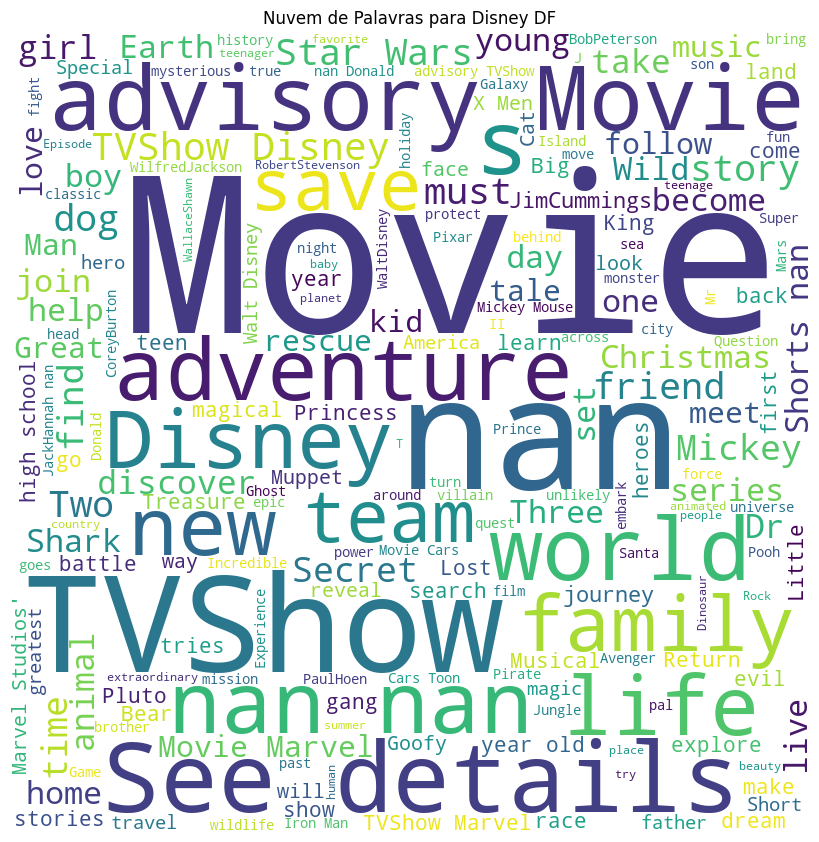

In [14]:
from wordcloud import WordCloud

tags_0 = ' '.join(disney_df_clean['tags'])

nuvem_palavras_0 = WordCloud(width=800, height=800, 
                             background_color='white', 
                             stopwords=None, 
                             min_font_size=10).generate(tags_0)

plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(nuvem_palavras_0) 
plt.axis("off") 
plt.tight_layout(pad=0) 

plt.title('Nuvem de Palavras para Disney DF')

plt.show()

### 2.3: Processar Coluna Tags

In [15]:
def processar_tags(tags):
    # Remover palavra 'nan'
    tags = re.sub(r"\b(nan|See details for advisory)\b", "", tags)
    # Substitui todos os caracteres não alfabéticos e não numéricos por espaços
    tags = re.sub(r"[^a-zA-Z0-9\s]", "", tags)
    # Substitui múltiplos espaços por um único espaço
    tags = re.sub(r'\s+', ' ', tags)
    # Converte o texto para minúsculas
    tags = tags.lower()
    return tags

In [16]:
def aplicar_processar_tags(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(str)
    dataframe[coluna] = dataframe[coluna].apply(processar_tags)

In [17]:
aplicar_processar_tags(disney_df_clean, 'tags')

In [18]:
disney_df_clean['tags'].head()

0    movie duck the halls a mickey mouse christmas ...
1    movie ernest saves christmas johncherry jimvar...
2    movie ice age a mammoth christmas karendisher ...
3    movie the queen family singalong hamishhamilto...
4    tvshow the beatles get back johnlennon paulmcc...
Name: tags, dtype: object

In [19]:
disney_df_clean['tags'][4]

'tvshow the beatles get back johnlennon paulmccartney georgeharrison ringostarr 2021 a threepart documentary from peter jackson capturing a moment in music history with the beatles'

### 2.4: Remover Stop Words

In [20]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yamas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def remover_stopwords(texto):
    palavras = texto.split()
    palavras_filtradas = [palavra for palavra in palavras if palavra not in stop_words]
    return ' '.join(palavras_filtradas)

In [22]:
def aplicar_remover_stopwords(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(str)
    dataframe[coluna] = dataframe[coluna].apply(remover_stopwords)

In [23]:
aplicar_remover_stopwords(disney_df_clean, 'tags')

In [24]:
disney_df_clean['tags'].head()

0    movie duck halls mickey mouse christmas specia...
1    movie ernest saves christmas johncherry jimvar...
2    movie ice age mammoth christmas karendisher ra...
3    movie queen family singalong hamishhamilton da...
4    tvshow beatles get back johnlennon paulmccartn...
Name: tags, dtype: object

In [25]:
disney_df_clean['tags'][4]

'tvshow beatles get back johnlennon paulmccartney georgeharrison ringostarr 2021 threepart documentary peter jackson capturing moment music history beatles'

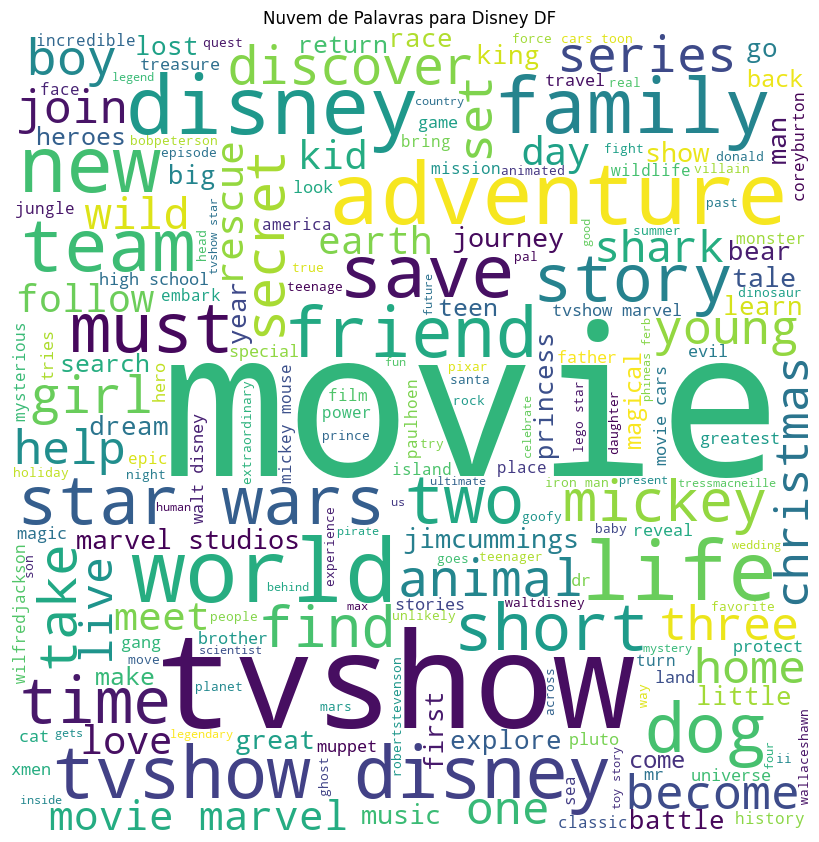

In [26]:
tags_0 = ' '.join(disney_df_clean['tags'])

nuvem_palavras_0 = WordCloud(width=800, height=800, 
                             background_color='white', 
                             stopwords=None, 
                             min_font_size=10).generate(tags_0)

plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(nuvem_palavras_0) 
plt.axis("off") 
plt.tight_layout(pad=0) 

plt.title('Nuvem de Palavras para Disney DF')

plt.show()

### 2.5: Aplicar Steeming

In [27]:
from nltk.stem import PorterStemmer

# Inicializa o stemmer
stemmer = PorterStemmer()

In [28]:
def stemming(texto):
    palavras = texto.split()
    palavras_stem = [stemmer.stem(palavra) for palavra in palavras]
    return ' '.join(palavras_stem)

In [29]:
def aplicar_stemming(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(str)
    dataframe[coluna] = dataframe[coluna].apply(stemming)

In [30]:
aplicar_stemming(disney_df_clean, 'tags')

In [31]:
disney_df_clean['tags'].head()

0    movi duck hall mickey mous christma special al...
1    movi ernest save christma johncherri jimvarney...
2    movi ice age mammoth christma karendish raymon...
3    movi queen famili singalong hamishhamilton dar...
4    tvshow beatl get back johnlennon paulmccartney...
Name: tags, dtype: object

In [32]:
disney_df_clean['tags'][4]

'tvshow beatl get back johnlennon paulmccartney georgeharrison ringostarr 2021 threepart documentari peter jackson captur moment music histori beatl'

### 2.6: Count Vectorizer

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [34]:
vector = vectorizer.fit_transform(disney_df_clean['tags']).toarray()

# Etapa 3: Construção de Modelo de Similaridade de Cosseno

### 3.1: Construir Modelo

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

# calcula a similaridade de cosseno utilizando o vetor
similarity = cosine_similarity(vector)

In [36]:
similarity.shape

(1450, 1450)

### 3.2: Criar Sistema de Recomendações

In [37]:
def recomendar(filme):
    index = disney_df_clean[disney_df_clean['title'] == filme].index[0]
    distancia = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distancia[1:11]:
        print(disney_df_clean.iloc[i[0]].title)

In [38]:
recomendar('Home Alone')

Home Alone 2: Lost in New York
Home Sweet Home Alone
Home Alone 3
I'll Be Home for Christmas
Dragon Around
America's Funniest Home Videos
Pluto's Christmas Tree
In Beaver Valley
Captain Sparky vs. The Flying Saucers
Mrs. Doubtfire


In [39]:
recomendar("101 Dalmatians")

102 Dalmatians
Cruella
101 Dalmatians II: Patch's London Adventure
101 Dalmatian Street
Puppy for Hanukkah
101 Dalmatians (Series)
Melody Time
Alice in Wonderland
Cinderella
Beach Picnic


In [40]:
recomendar("X-Men")

X2
X-Men: Evolution
X-Men: Days of Future Past
X-Men Origins: Wolverine
X-Men: The Last Stand
X-Men: First Class
X-Men: Apocalypse
Marvel Comics X-Men
X-Men: Dark Phoenix
Simpsons Movie


### 3.3: Criar Sistema de Recomendações Alternativo

In [ ]:
from fuzzywuzzy import process

def recomendar_alternativo(filme):
    filme = filme.lower()  # Padroniza o título inserido
    # Cria uma lista com os títulos do dataframe
    titles = disney_df_clean['title'].tolist()

    # Encontra o título mais próximo usando fuzzywuzzy
    best_match, score = process.extractOne(filme, titles)

    # Se o score for alto o suficiente (exemplo, 80 ou mais), pega o índice do filme
    if score > 50:
        matching_filmes = disney_df_clean[disney_df_clean['title'] == best_match]
        index = matching_filmes.index[0]
        distancia = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
        
        for i in distancia[1:11]:
            print(disney_df_clean.iloc[i[0]].title)
    else:
        print("Nenhum título encontrado com um bom grau de correspondência.")


In [42]:
recomendar_alternativo("Star wOrs")

LEGO Star Wars Holiday Special
Tick Tock Tale
LEGO Star Wars: The New Yoda Chronicles - Clash of the Skywalkers
LEGO Star Wars: Droid Tales
Star Wars Biomes
Mickey's Tale of Two Witches
Star Wars Vintage: Story of the Faithful Wookiee
Star Wars Vehicle Flythroughs
Star Wars: Visions
LEGO Star Wars: The Freemaker Adventures


In [43]:
recomendar_alternativo("toi estori")

Toy Story 3
Toy Story 2
Toy Story Toons: Small Fry
Toy Story of Terror!
Toy Story: That Time Forgot
Toy Story 4
Toy Story Toons: Hawaiian Vacation
Toy Story Toons: Partysaurus Rex
Tin Toy
Incredible! The Story of Dr. Pol
